In [94]:
'''
!pip install nselib
!pip install statsmodels
!pip install matplotlib
!pip install seaborn
!pip install tqdm
!pip install yfinance
'''

'\n!pip install nselib\n!pip install statsmodels\n!pip install matplotlib\n!pip install seaborn\n!pip install tqdm\n!pip install yfinance\n'

In [1]:
#Import necessary libraries and packages

import yfinance as yf
from nselib import capital_market as cm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import warnings

#Ignore time series warnings (Don't in practice)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
#Other Useful functions for capital_market package from nselib

#cm.bhav_copy_equities('02-07-2024')
#cm.bhav_copy_with_delivery('03-07-2024')

In [ ]:
#Pick ticker and retreives data from nse website

ticker = 'SBIN'
data = cm.deliverable_position_data(ticker,period='1Y') # or use from_date='' ... to_date=''

#Some dataframes held ClosePrice and PrevClose as objects instead of floats. 
#This converts it to floats regardless of that
data.loc[:,'ClosePrice'] = data.loc[:,'ClosePrice'].astype(str).str.replace(',', '').astype(float)
data.loc[:,'PrevClose'] = data.loc[:,'PrevClose'].astype(str).str.replace(',', '').astype(float)

In [59]:
#Filters dataset to required fields, creates PercentChange column, and drops Null

data_filtered = data.loc[:,['Date','ClosePrice','PrevClose']]
data_filtered.loc[:, 'PercentChange']=data_filtered['ClosePrice'].pct_change()*100
data_filtered = data_filtered.dropna()

In [60]:
#Creates returns dataframe with percent change data from data_filtered, indexed by Date

returns = data_filtered.loc[:,['Date','PercentChange']]
returns.loc[:, 'Date'] = pd.to_datetime(returns['Date'])
returns.set_index('Date', inplace=True)

In [61]:
#Creates prices dataframe with close price data from data_filtered, indexed by Date

prices = data_filtered.loc[:,['Date','ClosePrice']]
prices.loc[:, 'Date'] = pd.to_datetime(prices['Date'])
prices.set_index('Date', inplace=True)

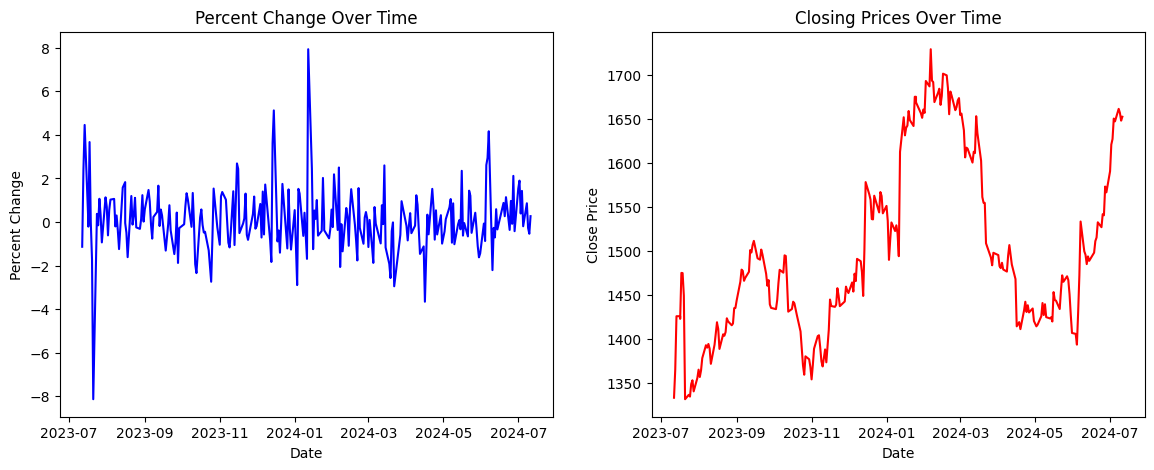

In [62]:
# Plots percent change and closing prices over time in two subplots

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(returns, linestyle='-', color='b')
ax1.set_title('Percent Change Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Percent Change')

ax2.plot(prices.index, prices['ClosePrice'], linestyle='-', color='r')
ax2.set_title('Closing Prices Over Time')
ax2.set_xlabel('Date')
ax2.set_ylabel('Close Price');

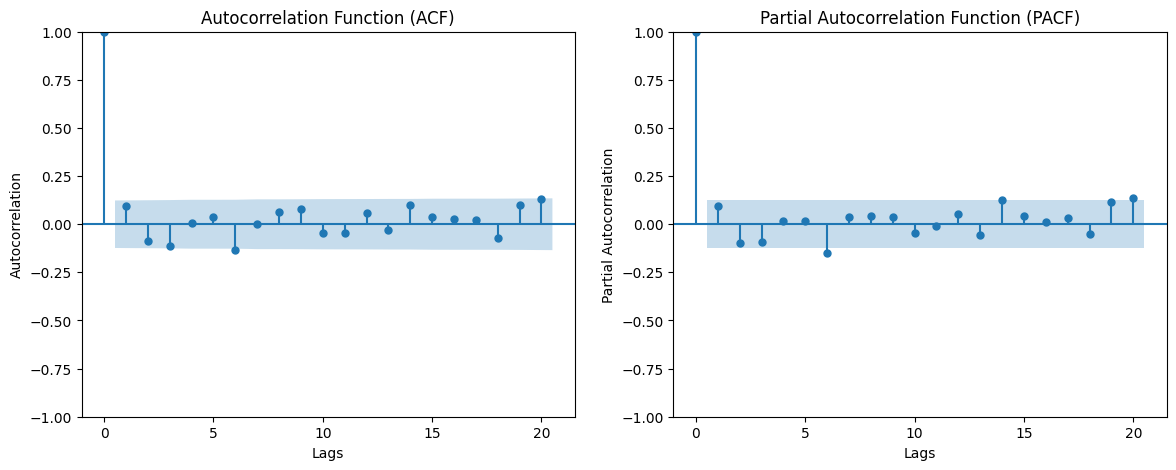

In [63]:
# Plots ACF and PACF for returns data with 20 lags

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(returns, ax=ax1, lags=20)
ax1.set_title('Autocorrelation Function (ACF)')
ax1.set_xlabel('Lags')
ax1.set_ylabel('Autocorrelation')

plot_pacf(returns, ax=ax2, lags=20)
ax2.set_title('Partial Autocorrelation Function (PACF)')
ax2.set_xlabel('Lags')
ax2.set_ylabel('Partial Autocorrelation');

In [64]:
#Generates a forecast date based on the last date.
def newdate(last_date) :
    if last_date.day_name() == 'Friday':
        forecast_date = last_date + timedelta(days=3)
    else:
        forecast_date = last_date + timedelta(days=1)

    return forecast_date

#Check if a model for the given ticker exists in the stored CSV file and is less than two weeks old.
def check_stored(ticker):
    df = pd.read_csv('stored_models.csv')
    
    if ticker in df['Ticker'].values:
        row = df[df['Ticker'] == ticker]
        last_updated = pd.to_datetime(row['last_updated'].values[0])
        two_weeks_ago = datetime.now() - timedelta(weeks=2)

        if last_updated>two_weeks_ago:
            best_p = row['Best_p'].values[0]
            best_q = row['Best_q'].values[0]
            print(f"Model found in file for Ticker: {ticker}, Best_p: {best_p}, Best_q: {best_q}")
            return best_p, best_q
        else:
            print(f"Model for {ticker} is older than two weeks.")
            return None, None
    else:
        print(f"Model for {ticker} has not been calculated.")
        return None, None

#Update the stored CSV file with the best parameters (best_p, best_q) for the given ticker and current timestamp.
def update_stored(ticker, best_p, best_q):
    df = pd.read_csv('stored_models.csv')
    
    new_row = pd.DataFrame({
        'Ticker': [ticker],
        'Best_p': [best_p],
        'Best_q': [best_q],
        'last_updated': [datetime.now()]
    })
    df = pd.concat([df, new_row], ignore_index=True)
    
    df.to_csv('stored_models.csv', index=False)
    print(f"CSV file updated with Ticker: {ticker}, Best_p: {best_p}, Best_q: {best_q}")

#Calculate the Mean Squared Error (MSE) between actual and predicted values.
def calculate_mse(actual, predicted):
    return np.mean((actual - predicted)**2)

#Perform ARIMA modeling to find the best (p, q) parameters based on MSE, optionally using stored values if recent.
def best_model(returns, ticker):

    best_p, best_q = check_stored(ticker)
    if best_p is not None and best_q is not None:
        return best_p, best_q
    else:
        half_index = len(returns) // 2
        training_data = returns.iloc[:half_index] 
        testing_data = returns.iloc[half_index:]
    
        mse_values = []
    
        for p in range(5):
            for q in range(5):
                try:
                    training_data_pred = training_data.copy()
                    
                    model = ARIMA(training_data, order=(p,0,q)).fit()
                    pred = model.forecast()
                    training_data_pred.loc[testing_data.index[0]] = pred.iloc[0]
                    
                    for i in range(len(testing_data)-1):
                        model = ARIMA(training_data_pred, order=(p,0,q)).fit()
                        pred = model.forecast()
                        training_data_pred.loc[testing_data.index[i+1]] = pred.iloc[0]
        
                    mse = calculate_mse(returns['PercentChange'], training_data_pred['PercentChange'])
                    mse_values.append((p, q, mse))
    
                    if (p + q) % 5 == 0:
                        print("Loading...") 
                    
                except Exception as e:
                    print(f"ARIMA({p}, 0, {q}) failed: {str(e)}")
                    continue
    
        best_p, best_q, min_mse = min(mse_values, key=lambda x: x[2])
        update_stored(ticker, best_p, best_q)
        
        print(f"Best (p, q) = ({best_p}, {best_q}) with MSE = {min_mse}")
        return best_p,best_q

In [65]:
best_p, best_q = best_model(returns,ticker)

Model found in file for Ticker: INFY, Best_p: 4, Best_q: 2


In [66]:
#Fits an ARIMA model to returns data with parameters best_q (MA order), best_p (AR order), and forecasts the next value.

model = ARIMA(returns, order=(best_p,0,best_q)).fit()
pred = model.forecast()

In [67]:
#Calculates the forecasted return and price.
forecast_return = pred.iloc[0]
forecast_price = prices['ClosePrice'].iloc[-1]*(1+(forecast_return/100))

#Calculates forecast date
last_date = prices.index[-1]
forecast_date = newdate(last_date)

Text(2024-07-12 00:00:00, 1637.173030059759, 'Forecast:\nDate: 12-07-2024\nPrice: 1653.71\nReturn:0.06%')

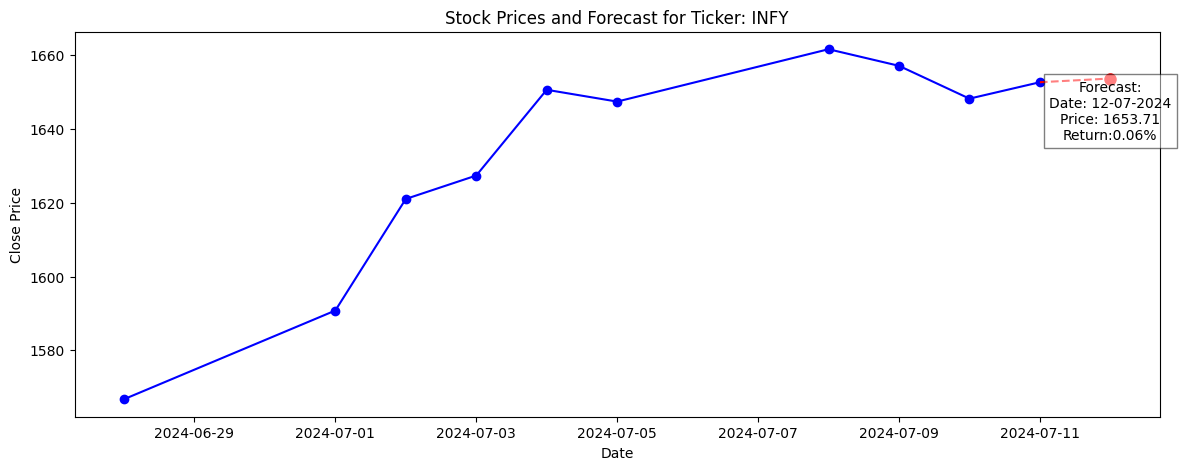

In [68]:
#Plots last 10 prices
plt.figure(figsize=(14, 5))
plt.plot(prices.tail(10), linestyle='-', color='b', marker='o')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'Stock Prices and Forecast for Ticker: {ticker}');

#Plots forecasted price and draws a dotted line to connect it to the last known price
plt.plot(forecast_date, forecast_price, marker='o', markersize=8, color='r', label='Forecasted Price')
plt.plot([last_date, forecast_date], [prices.loc[last_date, 'ClosePrice'], forecast_price], linestyle='--', color='r')

#Annotates the forecast details with a text box on the plot.
format_forcastD = forecast_date.strftime('%d-%m-%Y')

plt.text(forecast_date, forecast_price*0.99,
         f'Forecast:\nDate: {format_forcastD}\nPrice: {forecast_price:.2f}\nReturn:{forecast_return:.2f}%', 
         fontsize=10, ha='center', bbox=dict(facecolor='white', alpha=0.5))